# Предобработка данных

### Импортирование библиотек и языковой модели для spaCy
 ________________________________________________________________________________________________

Здесь мы импортируем библиотеку pandas для работы с нашим датасетом, саму spacy для нашей нейронной сети и загружаем в переменную nlp языковую модель, которую мы предварительно скачали с официальной документации spaCy

In [1]:
import pandas as pd
from spacy.tokens import DocBin
import spacy
nlp = spacy.load('ru_core_news_lg')

### Чтение обучающийх данных
___________________________________________________________________________________

В данном сегменте происходит чтение json файла с обучающей выборкой при помощи библиотеки pandas. После чего требовалось произвести форматирование: были удалены спецсимволы переноса строки и опущен столбец id, оставленный автором датасета, также был убран "нейтральный" сентимент. 

In [3]:
train_pd = pd.read_json('train.json', orient='records')
train_pd['text']=train_pd.text.str.replace('\n','')
train_pd = train_pd.drop('id', axis=1)

In [22]:
train_pd.drop(train_pd[train_pd.sentiment == 'neutral'].index, inplace=True)
train_pd.head(1)

,text,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,negative


In [6]:
full_data = train_pd.values.tolist()

In [8]:
split = int(len(full_data)*0.8)
train = full_data[:split]
valid = full_data[split:]

In [11]:
def make_docs(data):
    docs = []
    for doc, label in nlp.pipe(data, as_tuples = True):
        if label == 'negative':
            doc.cats['positive'] = 0
            doc.cats['negative'] = 1
        if label == 'positive':
            doc.cats['positive'] = 1
            doc.cats['negative'] = 0
        docs.append(doc)
    return (docs)

### Запись данных в отдельные файлы для обучения модели.
________________________________________________________________________________

Поскольку наша модель принимет на вход ТОЛЬКО файл-конфигурации (файл с ее настройками, который можно найти в документации библиотеки), то в этом файле нужно указать путь к двум текстовым файлам с нашими отформатированными выборками. В этом сегменте кода мы просто форматируем наши выборки с помощью функции, написанной в предыдущем сегменте и записываем их на диск с указанием пути.

In [13]:
doc_bin = DocBin(docs = make_docs(train))
doc_bin.to_disk('./data/train.spacy')

doc_bin = DocBin(docs = make_docs(valid))
doc_bin.to_disk('./data/valid.spacy')

# Запуск обучения модели
___________________________________________________________________________________________________________

Две строчки кода внизу просто запускают файл-конфигурации модели в терминале нашей рабочей среды (мы использовали jupyter notebook в качестве среды разработки). в этом файле конфигурации, мы, за кадром, вписали пути к нашим выборкам. После чего наша модель начинает обучение и сразу проверяется на валидационной выборке.

In [ ]:
python -m spacy init fill-config ./base_config.cfg config.cfg
python -m spacy train config.cfg --output ./output

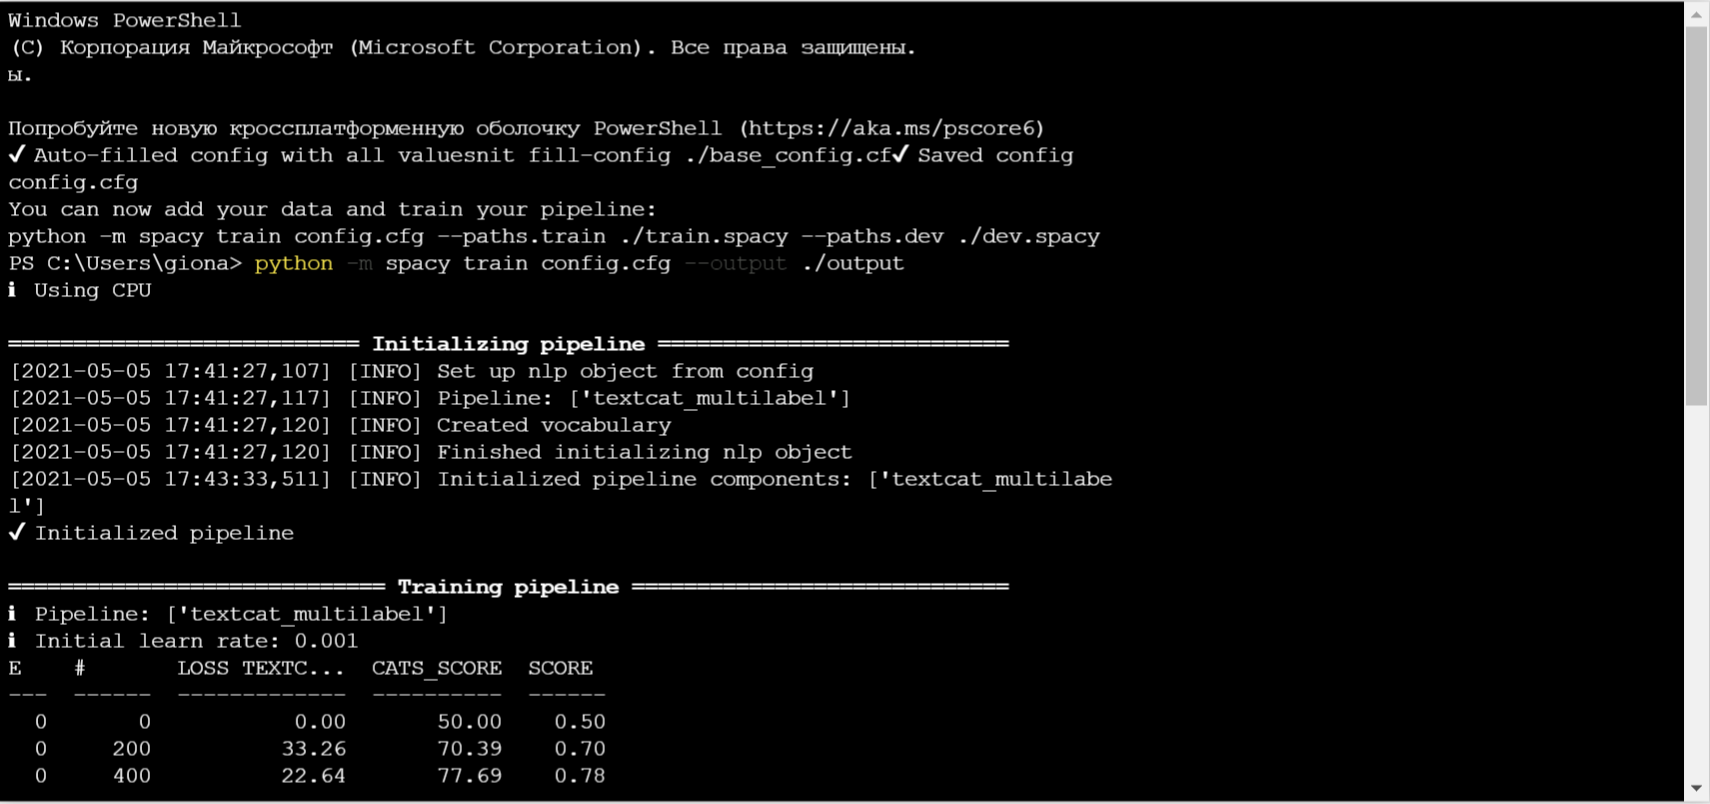

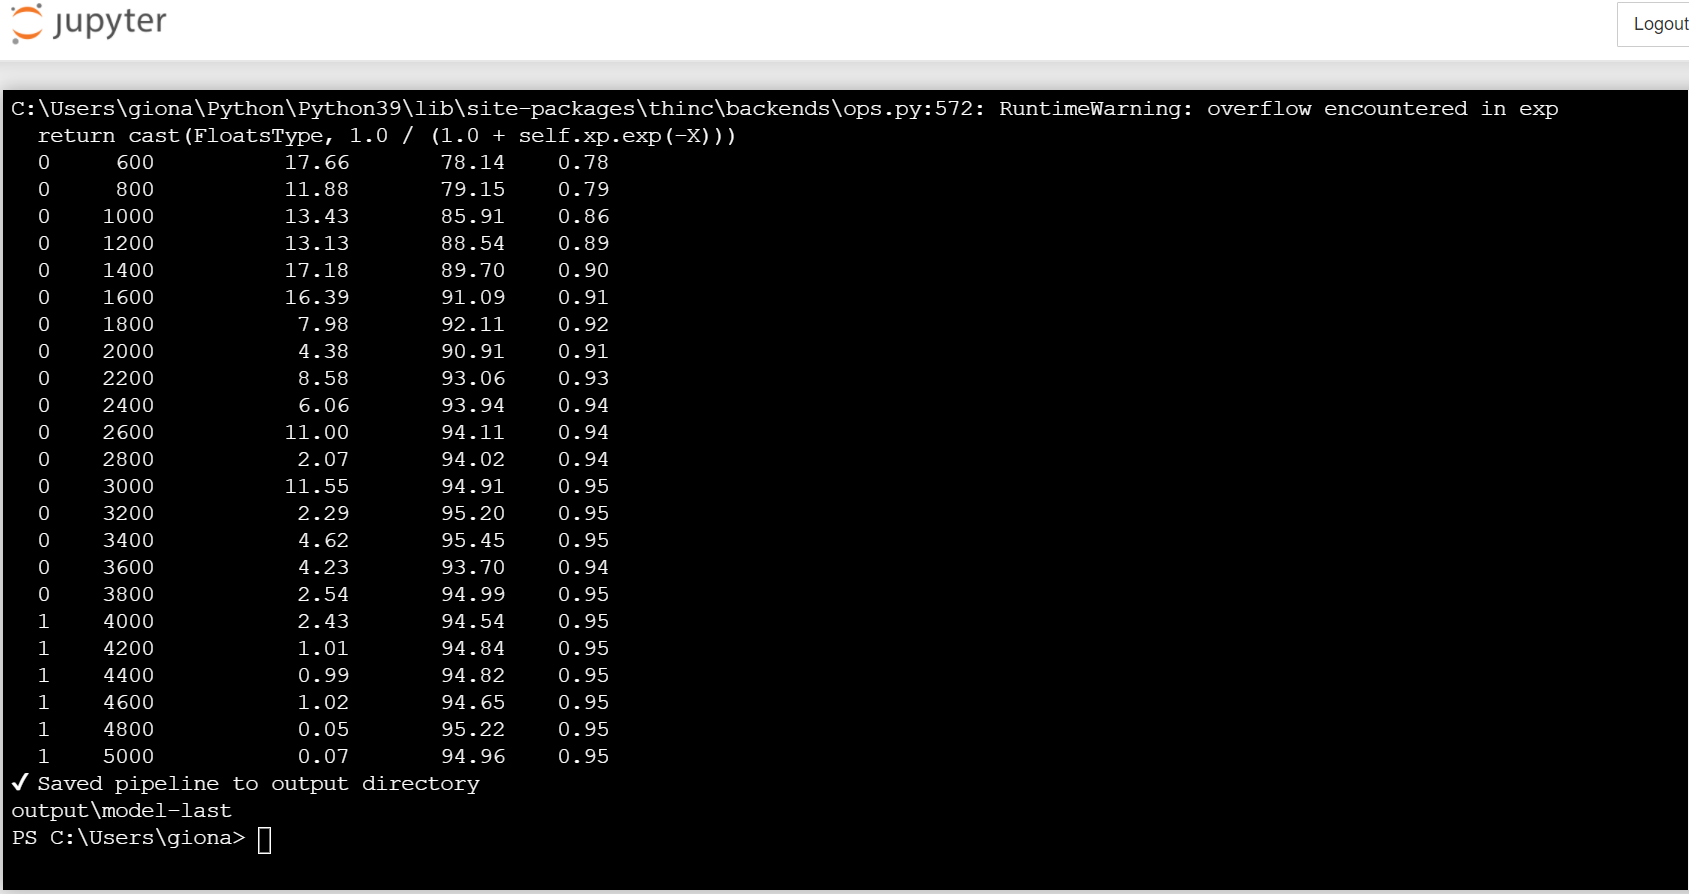

# Создание парсера
__________________________________________________________________________

Поскольку модели нужно проверить в рамках реальных данных (статьи по металлургии), эти данные нужно еще раздобыть. В данном сегменте кода мы импортируем библиотеку beautifulsoup для того, чтобы сделать из html-кода страницы структуру данных, по которой мы сможем спокойно ориентироваться и с которой можно будет работать. В нашем случае был выбран сайт metalinfo, здесь содержаться новостные сводки о металлургической области.

Здесь мы имеем две функции: get_html и parser_site. get_html позволяет нам отправить запрос сайту, с помощью библиотеки requests и, соответственно, через этот запрос скачать оттуда весь html код запрашиваемой страницы. Эта функция очень пригодится, так как вызывать ее придется часто - дело в том, что статьи хранятся под ссылками на основной странице, по которым тоже придется переходить и запрашивать html-код снова.

Функция parser_site является основной - самим парсером. Она, при указаниии аргмента (количество требуемых страниц со ссылками на статьи), начинает переходить по каждой ссылке на странице и копирует ТОЛЬКО текст статьи, после чего переходит по следующей ссылке и тд до конца страницы. Если это не последняя указанная страница, то парсер автоматически переходит на следующую страницу и проделывает то же самое. Каждую страницу парсер закидывает в список, который мы и будем использовать для проверки модели.

In [24]:
from bs4 import BeautifulSoup
import requests
url_tg = 'https://t.me/s/nerzhavey'
url_site = 'https://www.metalinfo.ru/ru/news/rferrous.html' #черная металлугрия
pure_url_site = 'https://www.metalinfo.ru'

def get_html(url, params = None):
    r = requests.get(url, params = params)
    return r.content        

#### Функция parser_site принимает аргументом количество страниц, которые нужно спарсить. На страницах расположены ссылки на полные статьи, которые нам нужны, поэтому скрипт проходит по каждой ссылке на полные статьи, достает их текст, и записывает в отдельную переменную string_blog

def parser_site(pages: int):
    final_blogs=[]
    refs = []
    for page in range(1, pages+1):
        print(f'\nParsing {page} page...\n')
        page_params = f'pn={page}' 
        #Достаем элементы страницы, в которых хранятся ссылки на нужные нам расширенные статьи
        html = get_html(url_site, page_params)
        soup = BeautifulSoup(html, 'html.parser')
        items = soup.find_all('div', class_= 'news-block clearfix')
        #Теперь мы проходимся по этим элементам и достаем из них ссылки
        for item in items:
            #Создаем переменную, в которой будет ханиться статья, а также, которая будет отчищать себя при переходе
            #на следующую страницу
            string_blog =''
            refs.append(item.find('a').get('href'))
            #Прекрпеляем ссылку к URL страницы и переходим на статью
            html = get_html(pure_url_site + refs[-1])
            soup = BeautifulSoup(html, 'html.parser')
            #Достаем весь текст статьи и сохраняем его в string_blog
            blog_text = soup.find('div', class_='news-body').section.find_all('p')
            for p in blog_text:
                string_blog +=' ' +p.text
            final_blogs.append(string_blog)
    return final_blogs
            


### Проверка

In [25]:
test_core = parser_site(1)


Parsing 1 page...



In [19]:
nlp = spacy.load('output/model-best')
prediction = nlp(test_core[1])
print(prediction.text)
print(prediction.cats)

 
В перечень предлагается включить железную руду, полуфабрикаты из железа или нелегированной стали, стальной прокат, а также медную заготовку, лом и отходы меди, медную и алюминиевую проволоку и необработанный алюминий, следует из проекта соответствующего постановления правительства, размещенного на сайте regulation.gov.ru. 
Предложение внесено "с целью возможности дальнейшего принятия мер по временному ограничению экспорта" этих товаров. 
В пояснительной записке к проекту постановления указано, что "начиная с IV квартала 2020 года отмечается восстановление отпускных цен на российском рынке металлопродукции, связанное с увеличением металлопотребления в мире, а также резкий рост стоимости котировок на мировых рынках закупаемого металлургического сырья: лома и ЖРС". 
Авторы документа напоминают, что "в целях недопущения дальнейшего роста цен на металлургическую продукцию" правительственной подкомиссией по таможенно-тарифному регулированию в декабре 2020 года уже было принято решение о по

# Построение модели на классических алгоритмах машинного обучения
___________________________________________________________________________________________________________________________

В данном сегменте мы посмотрим, насколько хорошо, по сравнению с нейронной сетью, показывают себя классические алгоритмы машинного обучения

Начнем с импортирования библиотек и методов, которые нам пригодятся. Первым делом импортируем векторайзер. Поскольку в библиотеке scikit нет встроенного в пайплайн (конвеер алгоритма) векторайзера, как в случае с spaCy, придется его импортировать и форматировать данные по нему, поскольку с чистыми словами мы работать не можем. Далее импортируем сами алгоритмы с настройками по умолчанию (нам больше этих настроек не нужно, они и без этого хорошо работают, да изначально эта библиотека предназначается для быстрого запуска или же *работы из коробки*). И, конечно же, разделим нашу выборку на тренировочную и валидационную.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report




vectorizer = CountVectorizer()


X = train_pd['text']
y = train_pd['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None)

### Метод наивного баесовского классификатора
____________________________________________________________________________________

В дальнейших сегментах кода будет менятся только применяемый метод (алгоритм), поэтому они все похожи: вызываем нужный метод (алгоритм), обучаем его на обучающей выборке, проверяем и выводим проверку.

In [30]:
NB = MultinomialNB()
NB.fit(vectorizer.fit_transform(X_train), y_train)
prediction = NB.predict(vectorizer.transform(X_test))
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

    negative       0.85      0.86      0.86       293
    positive       0.93      0.92      0.92       553

    accuracy                           0.90       846
   macro avg       0.89      0.89      0.89       846
weighted avg       0.90      0.90      0.90       846



### Метод логистической регрессии
____________________________________________________________________________________

In [32]:
logreg = LogisticRegression(random_state=42, max_iter = 100000)
logreg.fit(vectorizer.fit_transform(X_train), y_train)
prediction_logistic = logreg.predict(vectorizer.transform(X_test))
print(classification_report(y_test, prediction_logistic))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       293
    positive       0.93      0.94      0.94       553

    accuracy                           0.92       846
   macro avg       0.91      0.91      0.91       846
weighted avg       0.92      0.92      0.92       846



### Метод векторной машины
____________________________________________________________________________________

In [37]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(vectorizer.fit_transform(X_train), y_train)
pred_svm_test = svclassifier.predict(vectorizer.transform(X_test))
print(classification_report(y_test, pred_svm_test))


              precision    recall  f1-score   support

    negative       0.86      0.89      0.88       293
    positive       0.94      0.93      0.93       553

    accuracy                           0.91       846
   macro avg       0.90      0.91      0.90       846
weighted avg       0.91      0.91      0.91       846



### Проверка

In [39]:
print('SVM: ', svclassifier.predict(vectorizer.transform([test_core[1]])))

SVM:  ['positive']
